# A-6 Propeller Analysis

The next step in our analysis is one of the most difficult. We need to find out if the propeller can deliver that forward velocity we just predicted we will need to maintain level flight.

Most studies of propellers found in textbooks assume that the propeller is designed in an optimal way. It has a proper blade airfoil, and the pitch is distributed in a logical manner. Unfortunately, all of that goes out the window when we look at an A-6 propeller! The blade is a flat plate and is attached to the prop spar at some fixed angle. No nice airfoil section, and no pitch distribution. THis is one bad design, but it is easy to build! We are not even allowed to round off the edges of the blade! We are allowed to come up with some blade shape, so the chord distribution is something we can vary.

I used *WebPlotDigitizer* to digitize the *Wart* blade outline. Next, I created a flat plate section using the same approach shown with the simplex airfoil. That meant a round leading edge and a tapered trailing edge to help keep *Xfoil* happy. I was able to obtain lift and drag distributions from that work. The next challenge involves getting thrust and torque estimates for this blade. 

In [40]:
import os
import sys
from pathlib import Path
cwd = !pwd
pagedir = Path(cwd[0])

projpath = pagedir / ".." / ".."
projdir = projpath.absolute().as_posix()
if not projdir in sys.path:
        sys.path.insert(0,projdir)

In [41]:
from IPython.display import Image

In [73]:
import os
import numpy as np


DIR = "../../mmtime/data/airfoils"
airfoil = "flat0001"
re = 3000

afname = f'{airfoil}_RE{re}.pol'
fname = os.path.join(DIR,airfoil, afname)
fname = os.path.abspath(fname)
print("loading:", fname)
if os.path.isfile(fname):
    print("decoding")
    columns = [
        "alpha",
        "CL",
        "CD",
        "CDp",
        "CM",
        "xtr_upper",
        "xtr_lower"
    ]
    try:
        data = np.genfromtxt(
            fname,
            skip_header=12,
            names=columns,
        )
    except OSError:
        data = np.array([])

loading: /Users/rblack/_dev/live-2022/mmtime/data/airfoils/flat0001/flat0001_RE3000.pol
decoding


In [74]:
dpath = os.path.join(DIR,airfoil)
alpha = data['alpha']

In [7]:
dpath

'../../mmtime/data/airfoils/flat0001'

In [75]:
# create CL file
dname = os.path.join(dpath, 'CL.csv')
CL = data['CL']

In [76]:
print("Writing CL file:", dpath)
with open(dname,'w') as fout:
    for i in range(len(alpha)):
        fout.write(f'{alpha[i]}, {CL[i]}\n')

Writing CL file: ../../mmtime/data/airfoils/flat0001


In [77]:
# create CD file
dname = os.path.join(dpath, 'CD.csv')
CD = data['CD']

In [78]:
print("Writing CD file:", dname)
with open(dname,'w') as fout:
    for i in range(len(alpha)):
        fout.write(f'{alpha[i]}, {CD[i]}\n')

Writing CD file: ../../mmtime/data/airfoils/flat0001/CD.csv


In [79]:
# create CM file
dname = os.path.join(dpath, 'CM.csv')
CM = data['CM']

In [80]:
print("Writing CM file:", dname)
with open(dname,'w') as fout:
    for i in range(len(alpha)):
        fout.write(f'{alpha[i]}, {CM[i]}\n')

Writing CM file: ../../mmtime/data/airfoils/flat0001/CM.csv


In [81]:
# create CDp file
dname = os.path.join(dpath, 'CP.csv')
CP = data['CDp']

In [82]:
print("Writing CP file:", dname)
with open(dname,'w') as fout:
    for i in range(len(alpha)):
        fout.write(f'{alpha[i]}, {CP[i]}\n')

Writing CP file: ../../mmtime/data/airfoils/flat0001/CP.csv


In [84]:
import mmtime

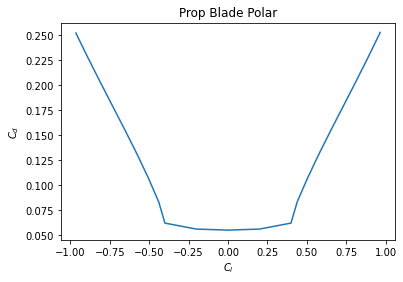

In [87]:
from mmtime.utils import show_curve
import matplotlib.pyplot as plt
show_curve(CL,CD,"Prop Blade Polar","$C_l$","$C_d$")

# Wart Propeller Blade

Using *WebPlotDigitizer*, I digitized the propeller blade outline from Gary's plan. Here is the outline image:

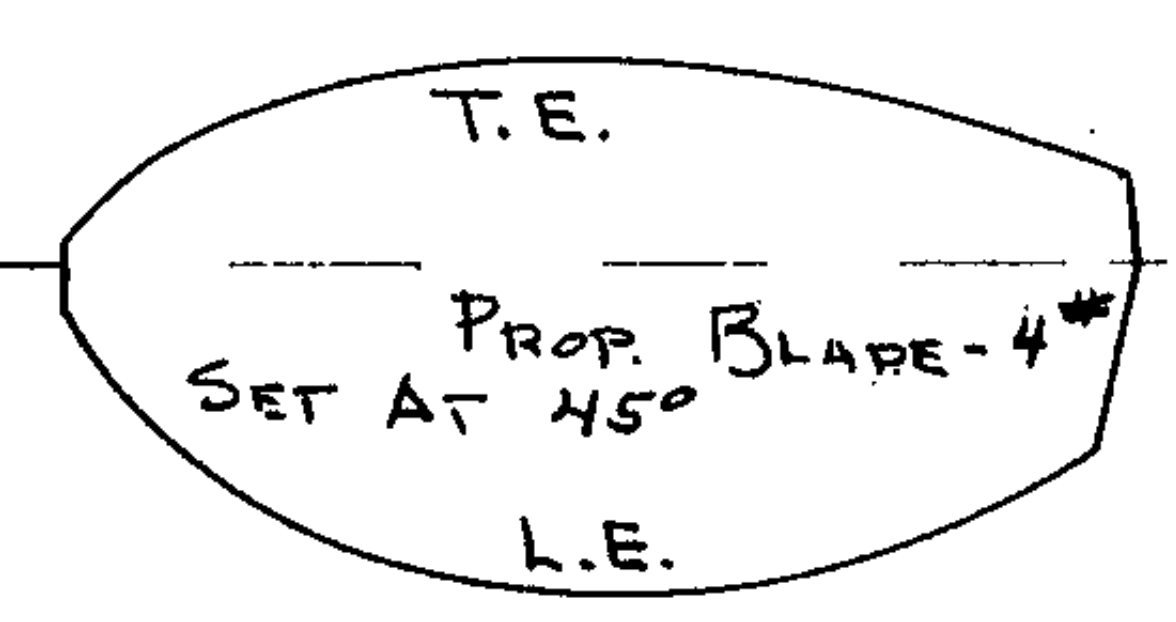

In [88]:
fname = projpath / 'assets' / 'images' / 'prop-blade.png'
Image(filename = fname)

The blade is 2.5 inches long and is attached to a shaft with 0.5 inch clearance to get to the six inch maximum diameter allowed for this class. The leading edge and trailing edge were digitized separately.

In [89]:
import csv
from scipy.signal import savgol_filter
from scipy import interpolate

In [90]:
lename = projpath / 'assets' / 'hodson-wart' / 'propeller' / 'blade-le.csv'
tename = projpath / 'assets' / 'hodson-wart' / 'propeller' / 'blade-te.csv'

In [91]:
 def fit_curve(x, y, smooth=False): # using a cubic spline
    if smooth:
        smooth_y = savgol_filter(y, 11, 3)
        fit = interpolate.CubicSpline(x,smooth_y)
    else:
        fit = interpolate.CubicSpline(x,y)
    return fit

In [92]:
def load_data(fname):
    x = []
    y = []
    with open(fname,'r') as fin:
        raw_data = csv.reader(fin,delimiter=',')
        for row in raw_data:
            x.append(float(row[0]))
            y.append(float(row[1]))
    dx = np.array(x)
    dy = np.array(y)
    fit = fit_curve(dx, dy, True)
    return fit

In [93]:
lecurve = load_data(lename)

In [94]:
xp = np.linspace(0.5,3.0,20)
yple = lecurve(xp)

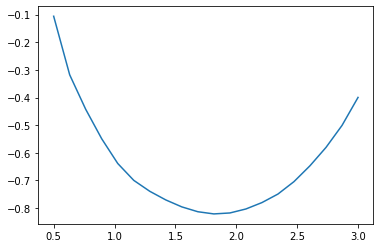

In [95]:
plt.plot(xp,yple)
plt.show()

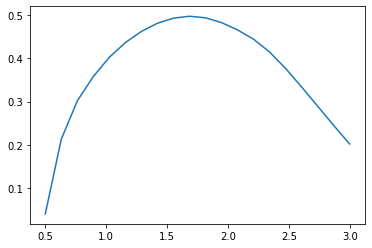

In [96]:


tecurve = load_data(tename)
ypte = tecurve(xp)
plt.plot(xp,ypte)
plt.show()

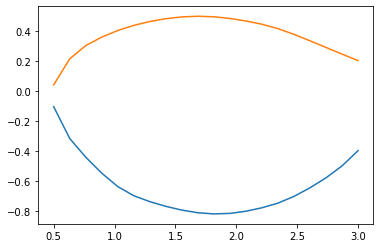

In [97]:
plt.plot(xp,yple)
plt.plot(xp,ypte)
plt.show()

Now, we need an array of propeller stations and chords.

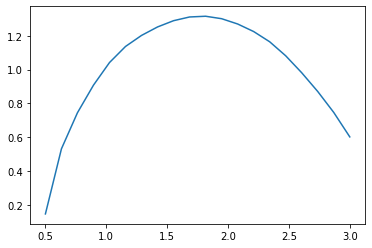

In [98]:
chord = ypte - yple
plt.plot(xp,chord)
plt.show()

The flying speed we want to analyze was found previously as 3.531 MPH. We will use our blade analysis scheme to determining the efficiency of this propeller for that speed.

## Load Blade Airfoil Data

In [65]:
from mmtime.AirfoilMgr import AirfoilMgr
am = AirfoilMgr('../../mmtime/data/airfoils')
#am.showAirfoils()
am.selectAirfoil('flat0001')
cl3, cd3, cm3, cp3 = am.loadData('re3k')

Selected: flat0001
Loading flat0001
	Loading CD_re3k.csv
	Loading CP_re3k.csv
	Loading CM_re3k.csv
	Loading CL_re3k.csv


## A6 Blade Element Theory Analysis

We start off by defining the basic blade parameters. We will be using units, so we need to set up **pint**:

In [66]:
import math
import pint
u = pint.UnitRegistry()

In [127]:
Vinf = 3.531 * u.miles / u.hour
pitch_angle = 45 * u.degrees
radius = 3 * u.inches
RPM = 3660 / (618 * u.seconds)
RPM = RPM * 1.1 # adustment for testing
rho = 1.1941523287329003 * u.kilogram / u.meter ** 3
omega = 2.0 * math.pi * RPM
Nblades = 2
R = xp * u.inches
C = chord * u.inches
print("omega",omega,"RPM",RPM)

omega 40.932207195315556 / second RPM 6.514563106796117 / second


Now we need to set up a basic analysis loop that iterates as shown previously. This scheme needs the local lift and drag coefficients for the blade section, which is a flat plate for the A6.

In [128]:
def velocities(V_d, a, b, rad_d, theta_d, omega):
        V0 = V_d * (1 + a)
        V2 = omega*rad_d * (1 - b)
        v0m = V0.to_base_units().magnitude
        v2m = V2.to_base_units().magnitude
        phi_d = math.atan2(v0m,v2m)*180.0/math.pi*u.degrees
        alpha = theta_d - phi_d
        Vlocal = ((V0**2 + V2**2)**0.5).to_base_units()
        Cl_l = cl3(alpha)
        Cd_l = cd3(alpha)
        #print(V0, V2, phi_d, alpha, Cl_l, Cd_l, Vlocal)
        return V0, V2, phi_d,alpha, Cl_l, Cd_l, Vlocal

In [129]:
a = 0.1
b = 0.001
pitch = 45 * u.degrees
rad = R[10]
bchord = C[10]
velocities(Vinf, a, b, rad, pitch, omega )

(3.8841000000000006 <Unit('mile / hour')>,
 74.24994668895516 <Unit('inch / second')>,
 42.63503262972799 <Unit('degree')>,
 2.364967370272012 <Unit('degree')>,
 array(0.1876561),
 array(0.0585846),
 2.5635340634223223 <Unit('meter / second')>)

In [130]:
def BET(V_d,rho_d,R_d,P_d,C_d,Cl,Cd):
    dia = 2 * radius
    thrust=0.0
    torque=0.0
    rstep = 2.5/20 * u.inches
    B = 2
    # loop over each blade element
    for j in range(0,len(R_d)):
        rad=R[j].to_base_units()
        chord = C_d[j].to_base_units()
        
        theta= pitch_angle                     # calculate local blade element setting angle
        sigma=2.0*chord/2.0/math.pi/rad        # calculate solidity    
        a=0.1                                  # guess initial values of inflow and swirl factor
        b=0.01
        finished=False                         # set logical variable to control iteration
        sum=1                                  # set iteration count and check flag
        itercheck=0
        #print("V",V,rad,theta,sigma)
        while not finished:
            V0, V2, phi, alpha, cl, cd, Vlocal = velocities(V_d, a, b, rad, theta, omega)
            
            phi_r = phi*math.pi/(180.0*u.degrees)  # radians
            #print("phi",phi, phi_r)
            q_l = 0.5*rho*Vlocal**2
            DtDr=q_l*B*chord*(cl*math.cos(phi_r)-cd*math.sin(phi_r))   # thrust grading    
            DqDr=q_l*B*chord*rad*(cd*math.cos(phi_r)+cl*math.sin(phi_r))   # torque grading
            tem1=DtDr/(4.0*math.pi*rad*rho*V_d**2*(1+a))  # momentum check on inflow and swirl factors
            tem2=DqDr/(4.0*math.pi*rad**3*rho*V_d*(1+a)*omega)
            anew=0.5*(a+tem1)    # stabilise iteration
            bnew=0.5*(b+tem2)
            #print((DtDr*rstep).to_base_units())
            # check for convergence
            #print(sum,a,anew,b,bnew)
            if abs(anew-a)<1.0e-5: 
                if abs(bnew-b)<1.0e-5:
                    finished=True
                    #print("converged in",sum,"iterations")
            a=anew
            b=bnew
            # increment iteration count
            sum=sum+1
            # check to see if iteration stuck
            if sum>500:
                finished=True
                itercheck=1
                print("convergence failed",V,rad,a,anew)
        thrust=thrust+DtDr*rstep
        #print("thrust",thrust.to_base_units())
        torque=torque+DqDr*rstep
    thrust_coef = thrust/(rho*RPM**2*dia**4)
    torque_coef = torque/(rho*RPM**2*dia**5)
    advance_ratio = V_d/(RPM*dia)
    prop_efficiency = advance_ratio * thrust_coef/(2*math.pi*torque_coef)
    print("C_T",thrust_coef.to_base_units(), 
          "\nC_Q",torque_coef.to_base_units(),
          "\nJ",advance_ratio.to_base_units(), 
          "\neta_p",prop_efficiency.to_base_units(),
          "\nThrust",thrust.to_base_units(),
          "\ntorque",torque.to_base_units())

In [131]:
BET(Vinf, rho,R, pitch_angle, C, cl3,cd3)

C_T 0.10100553783631613 dimensionless 
C_Q 0.05384840782963386 dimensionless 
J 1.589914754098361 dimensionless 
eta_p 0.4746421361906486 dimensionless 
Thrust 0.0027613113268022027 kilogram * meter / second ** 2 
torque 0.00022435100669020795 kilogram * meter ** 2 / second ** 2


In [132]:
T = 0.0027613113268022027 * u.kg*u.meter/u.second**2

This thrust if not what we want. It is off by a significant amount. Perhaps just picking the average RPM using the flight time ans winds is not a good idea. We need more information about the source of power - the rubber band.